### Train a Simple Classifier

In our first session we learned about training a classifier on the MNIST Images. The thing about MNIST though is the dataset is very simple! Today we will repeat this, but with a slightly more complex dataset known as CIFAR10. This will also motivate why we love Convolutions later!



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


### Lets Explore the Data

We will load the data here, lets take a quick look at what it looks like!

Files already downloaded and verified


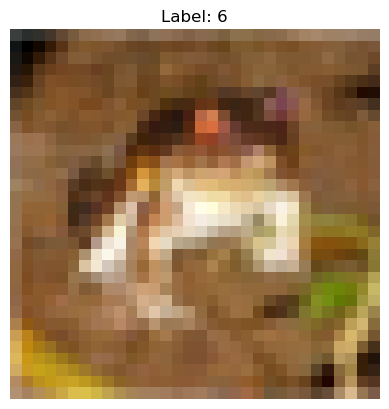

In [2]:
# Apply any necessary transforms (like converting PIL Image to Tensor if needed later)
transform = transforms.ToTensor()

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# Grab a sample image and label
sample, label = trainset[0]  # You can just index directly

# Display it
plt.imshow(np.array(sample))  # sample is a PIL image by default
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Thats a Frog! Just like MNIST there are 10 classes of images that we need to classify between!

### Define a Model

You can use any model shape you want, just use Linear layers only though. This means you can test how many hidden nodes to have in intermediate layers, and also how many layers you want in total. You can also play with different activation functions to see what works better!

In [17]:
class CIFAR10(nn.Module):
    def __init__(self, classes=10, dropout_p=0.5):  # CIFAR-10 has 10 classes
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 192 x 8 x 8
            nn.BatchNorm2d(192),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 4 x 4
            nn.BatchNorm2d(256),
        )

        self.head = nn.Sequential(
            nn.Flatten(),  # Flatten to shape: (256*4*4)
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.head(x)
        return x


### Define a Dataloader

We Now need to prepare our dataloader with the batch size we want to train with! I provide the datasets here (with some simple image transforms such as converting PIL to tensor and then normalizing). Create the dataloaders from that!

In [16]:
#Adding randomness to the training data for regularization
    #This will be used for training the model, not testing.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3),
])

#Keeping the same for the training phase
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Set batch size
BATCH_SIZE = 64  # You can change this to 32, 128, etc., depending on your system

# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Train a Model

Train your model for however many epochs you want. Make sure to calculate the average loss and accuracy per epoch for both the training set and evaluation set so we can plot our training curves after!

Things we need to set:

- Device
- Loss Function (what loss do we use for classification?)
- Optimizer (you can use whatever you want, and whatever learning rate you want)

In [20]:
### Set the Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

### Set the Loss Function ###
criterion = nn.CrossEntropyLoss()

### Load the Model ###
model = CIFAR10(classes=10).to(device)

### Set the Optimizer ###
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Loop ###
epochs = 20

# Store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    #Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    #Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_loss = val_loss / len(testloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
### First time running drop out rate set to .1 
    #This led to the best epoch at 9 
    #training acc 95.7% 
    #val acc 81.59%
    #Still seeing overfitting issues 
    ## Fixing the drop out to .3 and seeing if results get better.
    ### Drop out rate at .3
        #Best epoch at 6
        #training acc 91.23%
        #val acc 81.51%
        #roughly same results that dropout of .1 had 
        #overfitting issues
    ### Drop out rate at .5
        #produced the best results
        #At epoch 10
        # training acc 95.51%
        # val acc 83.05%
        #Overfitting is still evident, but not as much as before
### Now introducing randomness by utilizing horizontal flip / random crop to the transform
    ###This should help with the issue of overfitting.
    ###Best results
    ###Training and Testing are now producing values in line with eachother
    ###epoch 10
        # Training acc 86.90%
        # Val acc 84.60%
    ###Now going to run more epochs (20)
        ##Best epoch at 18
            #Training acc 91.67%
            #Val acc 88.22%
### No more overfitting with model 
### Val acc levels out around epoch 15

Epoch 1/20 | Train Loss: 1.4952 | Train Acc: 0.4585 | Val Loss: 1.0840 | Val Acc: 0.6095
Epoch 2/20 | Train Loss: 1.0352 | Train Acc: 0.6401 | Val Loss: 0.8907 | Val Acc: 0.6882
Epoch 3/20 | Train Loss: 0.8336 | Train Acc: 0.7145 | Val Loss: 0.6939 | Val Acc: 0.7621
Epoch 4/20 | Train Loss: 0.7106 | Train Acc: 0.7603 | Val Loss: 0.6617 | Val Acc: 0.7769
Epoch 5/20 | Train Loss: 0.6198 | Train Acc: 0.7918 | Val Loss: 0.6433 | Val Acc: 0.7839
Epoch 6/20 | Train Loss: 0.5543 | Train Acc: 0.8131 | Val Loss: 0.5479 | Val Acc: 0.8211
Epoch 7/20 | Train Loss: 0.5003 | Train Acc: 0.8318 | Val Loss: 0.4919 | Val Acc: 0.8361
Epoch 8/20 | Train Loss: 0.4639 | Train Acc: 0.8437 | Val Loss: 0.4594 | Val Acc: 0.8500
Epoch 9/20 | Train Loss: 0.4291 | Train Acc: 0.8575 | Val Loss: 0.4547 | Val Acc: 0.8546
Epoch 10/20 | Train Loss: 0.3996 | Train Acc: 0.8660 | Val Loss: 0.4445 | Val Acc: 0.8566
Epoch 11/20 | Train Loss: 0.3680 | Train Acc: 0.8764 | Val Loss: 0.4901 | Val Acc: 0.8469
Epoch 12/20 | Train

### Plot Loss and Accuracy

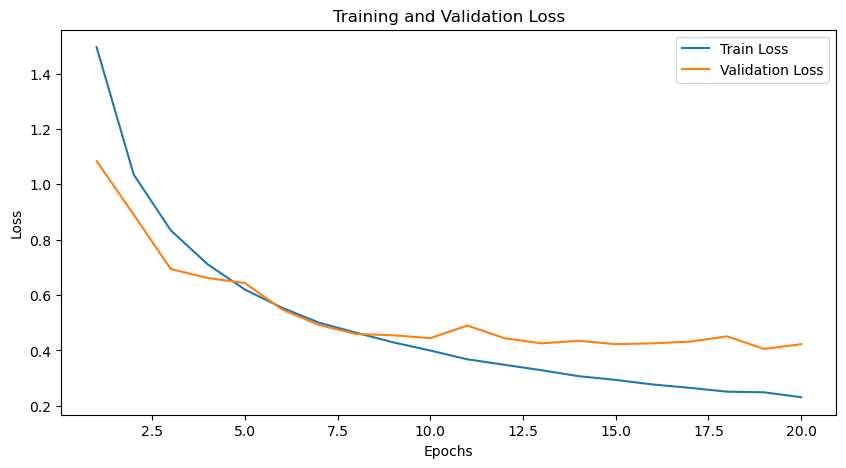

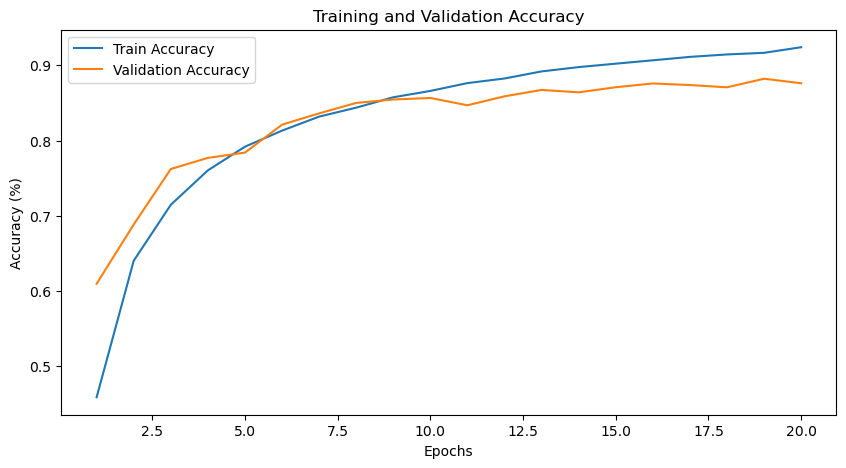

In [21]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()